# Predicting Sunspots with Neural Network (DNN only)

## Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

## Download and Preview the Dataset

In [3]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv

--2024-04-27 03:43:36--  https://storage.googleapis.com/tensorflow-1-public/course4/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [text/csv]
Saving to: ‘Sunspots.csv’

Sunspots.csv        100%[===================>]  69.17K   346KB/s    in 0.2s    

2024-04-27 03:43:37 (346 KB/s) - ‘Sunspots.csv’ saved [70827/70827]



In [4]:
# Preview the dataset
!head Sunspots.csv

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7
5,1749-06-30,139.2
6,1749-07-31,158.0
7,1749-08-31,110.5
8,1749-09-30,126.5


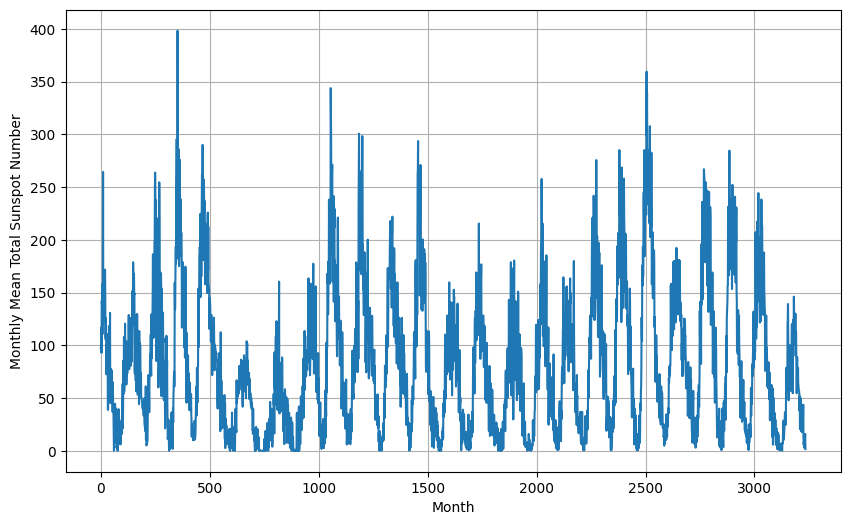

In [5]:
# Initialize lists
time_step = []
sunspots = []

# Open CSV file
with open('./Sunspots.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))

# Convert lists to numpy array
time = np.array(time_step)
series = np.array(sunspots)

# Preview the data
plot_series(time, series, xlabel='Month', ylabel='Monthly Mean Total Sunspot Number')

## Split the dataset

In [6]:
# Define the split time
split_time = 3000

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

## Prepare Features and Labels

In [7]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [8]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

## Build the Model

In [9]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                930       
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 1251 (4.89 KB)
Trainable params: 1251 (4.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Tune the Learning Rate

In [10]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 3s 5ms/step - loss: 55.9278 - lr: 1.0000e-08
Epoch 2/100
93/93 [==============================] - 0s 4ms/step - loss: 54.8169 - lr: 1.1220e-08
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 53.5926 - lr: 1.2589e-08
Epoch 4/100
93/93 [==============================] - 1s 8ms/step - loss: 52.2497 - lr: 1.4125e-08
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 50.7911 - lr: 1.5849e-08
Epoch 6/100
93/93 [==============================] - 1s 4ms/step - loss: 49.2161 - lr: 1.7783e-08
Epoch 7/100
93/93 [==============================] - 1s 4ms/step - loss: 47.5115 - lr: 1.9953e-08
Epoch 8/100
93/93 [==============================] - 0s 4ms/step - loss: 45.7070 - lr: 2.2387e-08
Epoch 9/100
93/93 [==============================] - 1s 4ms/step - loss: 43.8154 - lr: 2.5119e-08
Epoch 10/100
93/93 [==============================] - 1s 5ms/step - loss: 41.8254 - lr: 2.8184e-08
Epoch 11/100
93/93 

(1e-08, 0.001, 0.0, 100.0)

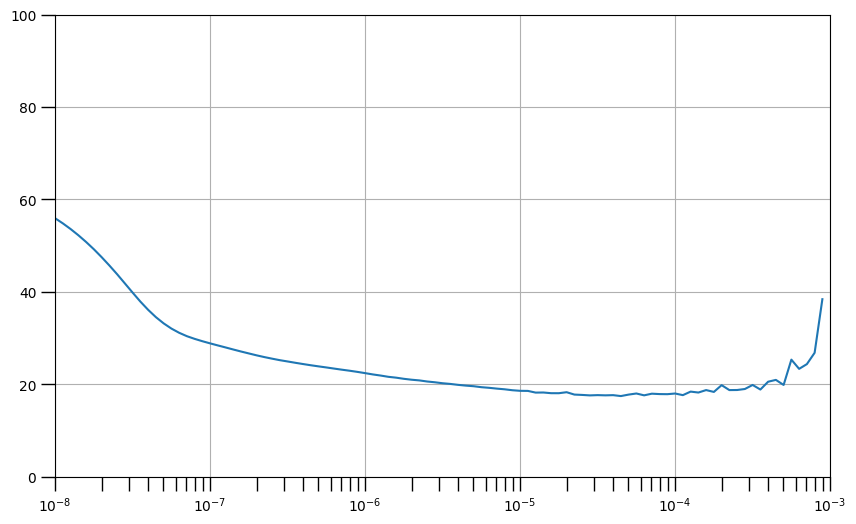

In [11]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

## Train the Model

In [12]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [13]:
# Set the learning rate
learning_rate = 2e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model.fit(train_set,epochs=100)

Epoch 1/100
93/93 [==============================] - 1s 5ms/step - loss: 31.9262 - mae: 32.4207
Epoch 2/100
93/93 [==============================] - 1s 5ms/step - loss: 20.7226 - mae: 21.2158
Epoch 3/100
93/93 [==============================] - 1s 5ms/step - loss: 19.4067 - mae: 19.9002
Epoch 4/100
93/93 [==============================] - 1s 5ms/step - loss: 18.9039 - mae: 19.3962
Epoch 5/100
93/93 [==============================] - 1s 4ms/step - loss: 18.9378 - mae: 19.4309
Epoch 6/100
93/93 [==============================] - 1s 5ms/step - loss: 18.6345 - mae: 19.1258
Epoch 7/100
93/93 [==============================] - 1s 7ms/step - loss: 18.4549 - mae: 18.9478
Epoch 8/100
93/93 [==============================] - 1s 6ms/step - loss: 18.1012 - mae: 18.5937
Epoch 9/100
93/93 [==============================] - 1s 7ms/step - loss: 18.0627 - mae: 18.5549
Epoch 10/100
93/93 [==============================] - 1s 9ms/step - loss: 17.7219 - mae: 18.2136
Epoch 11/100
93/93 [===================

## Model Prediction

In [14]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

8/8 [==============================] - 0s 9ms/step


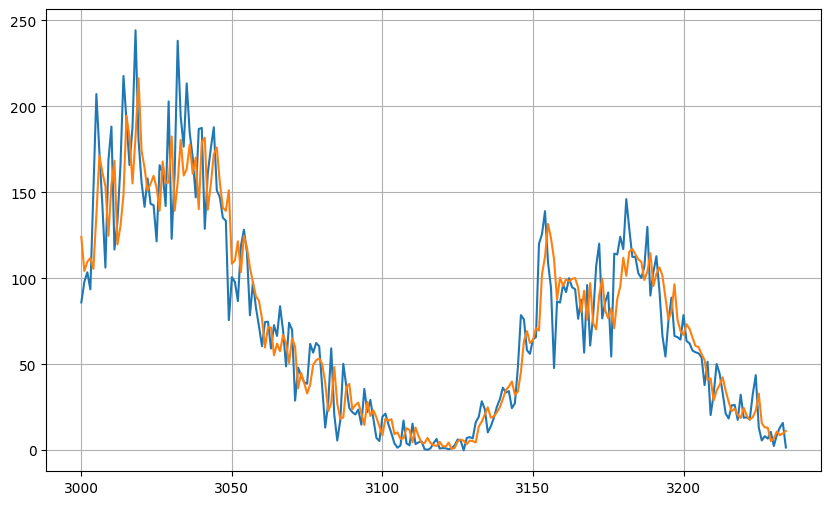

In [15]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))

In [16]:
# Compute the MAE
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

15.094088
